#**Gender Classification Deep Learning Model** 🤵🏻👩🏻
####In this notebok we will build a model to recognize male and female in a image.
## Problem :
#### We will build a Deep Learning Model which will differentiate between Female and Male in a Given Image and give a prediction rate
## Data :
#### The dataset used in this model has been taken from kaggle Datasets: [https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image]
## Data Features :
#### There 2 different categories:
####  Male
#### Female
#### Each class contain of almost 1700 images in total there are nearly 3400 images.

## Importing all Dependencies

In [17]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import random
import os
import datetime
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix
import itertools

## Getting data ready

In [18]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [19]:
unzip_data('drive/MyDrive/gender/gender.zip')

In [38]:
train_dir = 'drive/MyDrive/gender/train'
test_dir = '/content/drive/MyDrive/gender/valid'

In [39]:
os.listdir(train_dir)

['female', 'male']

In [40]:
def random_image(dir, classes):
  '''
  Function for viewing random images from the given data
  '''
  folder = dir+'/'+classes
  random_image = random.sample(os.listdir(folder),2)
  img = mpimg.imread(folder + '/' + random_image[1])
  plt.imshow(img)
  plt.title(classes)
  plt.axis('off')

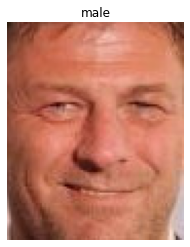

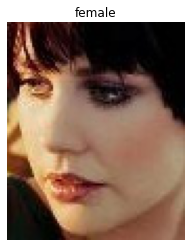

In [59]:
random_image('drive/MyDrive/gender/train', 'male')
plt.figure()
random_image('drive/MyDrive/gender/train', 'female')

## Preparing data from Modelling

In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCH = 10
INPUT_SHAPE = (224,224,3)

In [42]:
# using image_dataset_from_directory so that we can all data in our desired shape and in tf.dataset form
train_data = image_dataset_from_directory(train_dir,
                                          image_size=IMG_SIZE,
                                          label_mode='categorical',
                                          batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         image_size=IMG_SIZE,
                                         label_mode='categorical',
                                         batch_size=BATCH_SIZE)

Found 3491 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [26]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [60]:
train_data.class_names

['female', 'male']

In [69]:
def tensorboard(dirname, experiment_name):
  '''
  Create Tensorboard callback 
  '''
  log_dir = dirname + '/' + experiment_name + '/' + datetime.dateime.now().strftime('%Y&m%d-%H%M%S')
  tensorboard_callback = TensorBoard(log_dir=log_dir)
  print(f'Saving files in {log_dir}')
  return tensorboard

In [29]:
# create ModelCheckpoint callback
check_path = 'gender_checks'

checkpoint = ModelCheckpoint(check_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_accuracy')

In [30]:
# using data augmentation on our data
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1/255.)
], name = 'augmentation')

## Creating simple Functional Deep Learning Model 

In [43]:
from keras.engine import training
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = Dense(2, activation='sigmoid', name = 'output_layer')(x)
model = Model(inputs, outputs)

model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics='accuracy')

In [ ]:
# fitting the model
history = model.fit(train_data,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)),
                    callbacks=checkpoint)

## History

In [70]:
def plot_loss_curves(history):
  '''
  plotting all data in out history like accuracy and loss
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='validation_accuracy')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(history)

In [ ]:
# saving model
model.save('drive/MyDrive/gender/saved.h5')

In [ ]:
# loading model 
loaded_model = tf.keras.models.load_model('drive/MyDrive/gender/saved.h5')

In [45]:
results = loaded_model.evaluate(test_data, verbose=1)

7/7 [==============================] - 67s 182ms/step - loss: 0.2704 - accuracy: 0.9050


In [46]:
class_names = train_data.class_names

## Prediction on Test data

In [72]:
def load_prep_image(filename, image_shape=224, scale=True):
  '''
  This function takes image as an input, convert into tensors and resize it.
  So that it can be using for further process
  '''

  img = tf.io.read_file(filename) # read the image
  img = tf.io.decode_image(img) # decode the image
  img = tf.image.resize(img, (224, 224)) # resize image
  if scale:
    return img/255
  else:
    return img

1/1 [==============================] - 0s 29ms/step


<Figure size 1224x720 with 0 Axes>

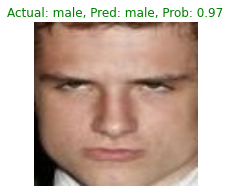

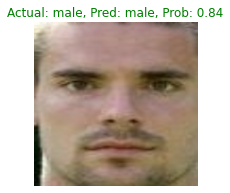

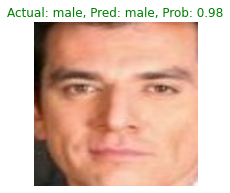

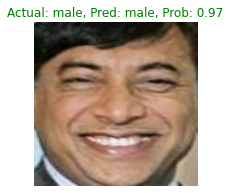

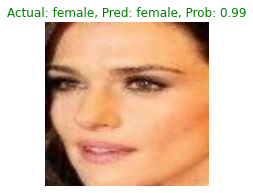

In [75]:
size = 5
plt.figure(figsize=(17, 10))
for i in range(size):
    # Choose a random image from a random class 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + '/'+ class_name + "/" + filename
    # Load the image and make predictions
    img = load_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.figure(figsize=(17, 10))
    plt.subplot(1, 5, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

## Prediction on Custom data

In [67]:
custom_gen_images = ['drive/MyDrive/custom/' + image_path for image_path in os.listdir('drive/MyDrive/custom')]
custom_images = custom_gen_images[2:]
custom_images

['drive/MyDrive/custom/OIP (6).jpg',
 'drive/MyDrive/custom/OIP (7).jpg',
 'drive/MyDrive/custom/OIP (8).jpg',
 'drive/MyDrive/custom/OIP (9).jpg',
 'drive/MyDrive/custom/OIP (10).jpg']

1/1 [==============================] - 0s 31ms/step


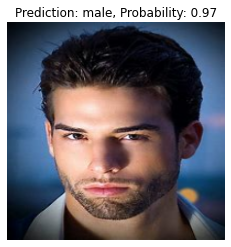

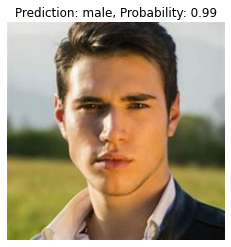

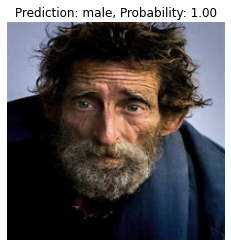

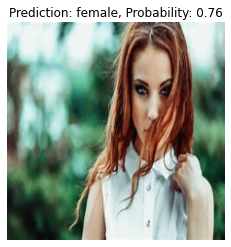

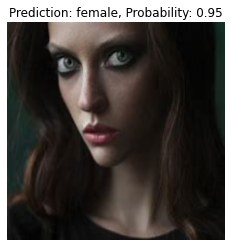

In [68]:
for img in custom_images:
  img = load_pred_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"Prediction: {pred_class}, Probability: {pred_prob.max():.2f}")
  plt.axis(False)

##Conclusion
### We have successfully build the model and also predicted on custom data
#### For any comments and advice please refer to yasirnotezai3@gmail.com